Домашку будет легче делать в колабе (убедитесь, что у вас runtype с gpu).

# Задание 1 (3 балла)

Обучите word2vec модели с негативным семплированием (cbow и skip-gram) аналогично тому, как это было сделано в семинаре. Вам нужно изменить следующие пункты:
1) добавьте лемматизацию в предобработку (любым способом)  
2) измените размер окна в большую или меньшую сторону
3) измените размерность итоговых векторов

Выберете несколько не похожих по смыслу слов (не таких как в семинаре), и протестируйте полученные эмбединги (найдите ближайшие слова и оцените качество, как в семинаре).
Постарайтесь обучать модели как можно дольше и на как можно большем количестве данных. (Но если у вас мало времени или ресурсов, то допустимо взять поменьше данных и поставить меньше эпох)

In [2]:
!pip install matplotlib pandas
!pip install --upgrade keras
# !pip install torch torchvision torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 58.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0


In [3]:
# import tensorflow as tf
import numpy as np
import pandas as pd
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances

# from IPython.display import Image
# from IPython.core.display import HTML
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


import re

from pymystem3 import Mystem

In [4]:
# в новой версии кераса можно использовать разные бекэнды, можно попробовать торч
# если заменить на tensorflow или jax то код также будет работать
# но нужно заранее установить нужный фреймворк

import os
os.environ["KERAS_BACKEND"] = "torch"
# os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import torch
# torch.set_default_device('cpu')

import keras
print(keras.__version__)

3.8.0


In [ ]:
# в нашем корпусе 20к текстов
wiki = open('wiki_data.txt').read().split('\n')

Предобрабатываем текст (лемматизируем его):

In [ ]:
mystem = Mystem()

In [ ]:
def preprocess(text):
    tokens = re.sub('#+', ' ', text.lower())

    lemmas = mystem.lemmatize(text)
    tokens = [token.strip(punctuation) for token in lemmas if token.strip(punctuation)]

    return tokens

Создаем словарь:

In [ ]:
vocab = Counter()

for text in wiki:
    vocab.update(preprocess(text))

In [ ]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [ ]:
word2id = {'PAD':0}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [ ]:
id2word = {i:word for word, i in word2id.items()}

Токенизируем текст:

In [ ]:
sentences = []

for text in wiki:
    tokens = preprocess(text)
    if not tokens:
        continue
    ids = [word2id[token] for token in tokens if token in word2id]
    sentences.append(ids)

Функция для нахождения наиболее похожих слов:

In [ ]:
def most_similar(word, embeddings):
    similar = [id2word[i] for i in
               cosine_distances(embeddings[word2id[word]].reshape(1, -1), embeddings).argsort()[0][:10]]
    return similar

**Negative sampling**

In [ ]:
vocab_size = len(id2word)

Skip Gram:

In [ ]:
def gen_batches_sg(sentences, window = 5, batch_size=1000):

    # параметр window задает его целиком
    # нам нужно поделить его пополам на левую и правую часть
    # когда делится неровно, то левая часть больше на 1
    left_context_length = (window/2).__ceil__() # округлить в большую сторону
    right_context_length = window // 2 # округлить в меньшую сторону

    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-left_context_length):i] + sent[i+1:i+right_context_length]
                for context_word in context:
                    X_target.append(word)
                    X_context.append(context_word)
                    y.append(1)

                    X_target.append(word)
                    X_context.append(np.random.randint(vocab_size))
                    y.append(0)

                    if len(X_target) >= batch_size:
                        X_target = np.array(X_target)
                        X_context = np.array(X_context)
                        y = np.array(y)
                        yield ((X_target, X_context), y)
                        X_target = []
                        X_context = []
                        y = []

In [ ]:
inputs_target_sg = keras.layers.Input(shape=(1,))
inputs_context_sg = keras.layers.Input(shape=(1,))


embeddings_target_sg = keras.layers.Embedding(input_dim=len(word2id), output_dim=200)(inputs_target_sg, )
embeddings_context_sg = keras.layers.Embedding(input_dim=len(word2id), output_dim=200)(inputs_context_sg, )

target_sg = keras.layers.Flatten()(embeddings_target_sg)
context_sg = keras.layers.Flatten()(embeddings_context_sg)

dot_sg = keras.layers.Dot(1)([target_sg, context_sg])
outputs_sg = keras.layers.Activation(activation='sigmoid')(dot_sg)

model_sg = keras.Model(inputs=[inputs_target_sg, inputs_context_sg],
                       outputs=outputs_sg)
optimizer_sg = keras.optimizers.Adam(learning_rate=0.001)
model_sg.compile(optimizer=optimizer_sg,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model_sg.fit(gen_batches_sg(sentences[:10000], window=10),
          validation_data=gen_batches_sg(sentences[10000:],  window=10),
          batch_size=1000,
          steps_per_epoch=10000,
          validation_steps=30,
          epochs=20)

Epoch 1/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 102s 10ms/step - accuracy: 0.8761 - loss: 0.2861 - val_accuracy: 0.8749 - val_loss: 0.2904
Epoch 2/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 102s 10ms/step - accuracy: 0.8747 - loss: 0.3034 - val_accuracy: 0.8772 - val_loss: 0.2974
Epoch 3/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 103s 10ms/step - accuracy: 0.8748 - loss: 0.3020 - val_accuracy: 0.8619 - val_loss: 0.3272
Epoch 4/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 102s 10ms/step - accuracy: 0.8749 - loss: 0.2994 - val_accuracy: 0.8637 - val_loss: 0.3500
Epoch 5/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 112s 11ms/step - accuracy: 0.8795 - loss: 0.2897 - val_accuracy: 0.8664 - val_loss: 0.3284
Epoch 6/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 106s 11ms/step - accuracy: 0.8741 - loss: 0.2990 - val_accuracy: 0.8900 - val_loss: 0.2744
Epoch 7/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 118s 12ms/step - accuracy: 0.8909 - loss: 0.2660 - val_accuracy: 0.8788 - val_loss: 0.2853
Epoch 8/20
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 114s 11ms/s

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


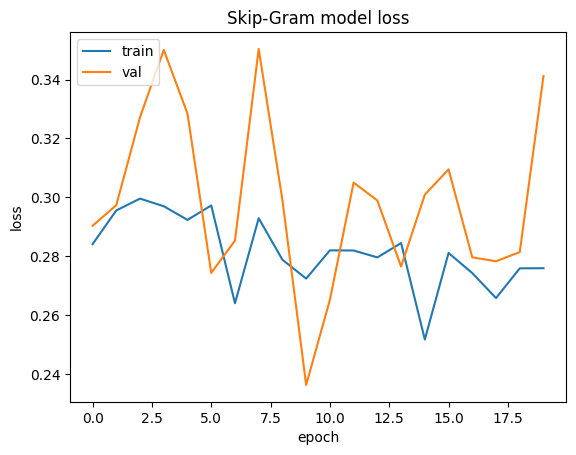

In [ ]:
print(model_sg.history.history.keys())
# summarize history for accuracy
plt.plot(model_sg.history.history['loss'])
plt.plot(model_sg.history.history['val_loss'])
plt.title('Skip-Gram model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
embeddings_sg = model_sg.layers[2].get_weights()[0]

In [ ]:
most_similar('лягушка', embeddings_sg)

['лягушка',
 'питаться',
 'насекомое',
 'бурый',
 'яйцо',
 'озерный',
 'красноватый',
 'клюв',
 'змей',
 'муравей']

In [ ]:
most_similar('эпоха', embeddings_sg)

['эпоха',
 'палеолит',
 'неолит',
 'династия',
 'поздний',
 'древний',
 'царство',
 'датироваться',
 'XIX',
 'барокко']

In [ ]:
most_similar('дорога', embeddings_sg)

['дорога',
 'железный',
 'станция',
 'трасса',
 'ветка',
 'шоссе',
 'автомобильный',
 'железнодорожный',
 'автодорога',
 'вокзал']

CBOW:

In [ ]:
def gen_batches_cbow(sentences, window = 5, batch_size=1000):

    # параметр window задает его целиком
    # нам нужно поделить его пополам на левую и правую часть
    # когда делится неровно, то левая часть больше на 1
    left_context_length = (window/2).__ceil__() # округлить в большую сторону
    right_context_length = window // 2 # округлить в меньшую сторону

    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                context = sent[max(0, i-left_context_length):i] + sent[i+1:i+right_context_length]

                X_target.append(word)
                X_context.append(context)
                y.append(1)

                X_target.append(np.random.randint(vocab_size))
                X_context.append(context)
                y.append(0)

                if len(X_target) == batch_size:
                    X_target = np.array(X_target)
                    X_context = keras.preprocessing.sequence.pad_sequences(X_context, maxlen=window)
                    y = np.array(y)
                    yield ((X_target, X_context), y)
                    X_target = []
                    X_context = []
                    y = []

In [ ]:
inputs_target_cbow = keras.layers.Input(shape=(1,))
inputs_context_cbow = keras.layers.Input(shape=(10,))


embeddings_target_cbow = keras.layers.Embedding(input_dim=len(word2id), output_dim=200)(inputs_target_cbow, )
embeddings_context_cbow = keras.layers.Embedding(input_dim=len(word2id), output_dim=200)(inputs_context_cbow, )

target_cbow = keras.layers.Flatten()(embeddings_target_cbow)
context_cbow = keras.layers.Lambda(lambda x: x.sum(axis=1))(embeddings_context_cbow)
dot_cbow = keras.layers.Dot(1)([target_cbow, context_cbow])

# полученную близость нужно преобразовать в вероятность
# когда она одна используется не софтмакс и сигмоида
outputs_cbow = keras.layers.Activation(activation='sigmoid')(dot_cbow)

model_cbow = keras.Model(inputs=[inputs_target_cbow, inputs_context_cbow],
                       outputs=outputs_cbow)


optimizer_cbow = keras.optimizers.Adam(learning_rate=0.001)
model_cbow.compile(optimizer=optimizer_cbow,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model_cbow.fit(gen_batches_cbow(sentences[:10000], window=10),
          validation_data=gen_batches_cbow(sentences[10000:],  window=10),
          batch_size=1000,
          steps_per_epoch=5000,
          validation_steps=30,
          epochs=20)

Epoch 1/20
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 65s 13ms/step - accuracy: 0.8717 - loss: 0.3044 - val_accuracy: 0.9098 - val_loss: 0.2316
Epoch 2/20
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 64s 13ms/step - accuracy: 0.9123 - loss: 0.2164 - val_accuracy: 0.9268 - val_loss: 0.1836
Epoch 3/20
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 64s 13ms/step - accuracy: 0.9278 - loss: 0.1773 - val_accuracy: 0.9214 - val_loss: 0.1949
Epoch 4/20
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 65s 13ms/step - accuracy: 0.9359 - loss: 0.1572 - val_accuracy: 0.9149 - val_loss: 0.2549
Epoch 5/20
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 66s 13ms/step - accuracy: 0.9413 - loss: 0.1440 - val_accuracy: 0.9212 - val_loss: 0.2187
Epoch 6/20
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 65s 13ms/step - accuracy: 0.9457 - loss: 0.1335 - val_accuracy: 0.9262 - val_loss: 0.1993
Epoch 7/20
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 64s 13ms/step - accuracy: 0.9504 - loss: 0.1228 - val_accuracy: 0.9192 - val_loss: 0.2177
Epoch 8/20
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 66s 13ms/step - accuracy: 0.9531 -

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


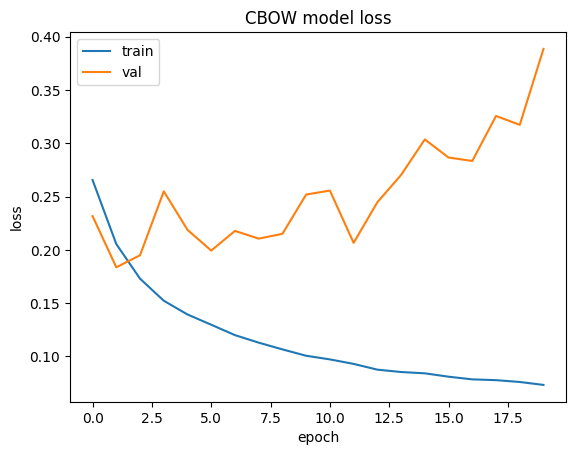

In [ ]:
print(model_cbow.history.history.keys())
# summarize history for accuracy
plt.plot(model_cbow.history.history['loss'])
plt.plot(model_cbow.history.history['val_loss'])
plt.title('CBOW model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
embeddings_cbow = model_cbow.layers[2].get_weights()[0]

In [ ]:
most_similar('потеря', embeddings_cbow)

['потеря',
 'понести',
 'нарушение',
 'нападение',
 'концентрация',
 'нагрузка',
 'устойчивость',
 'снижение',
 'потерять',
 'повышение']

In [ ]:
most_similar('документ', embeddings_cbow)

['документ',
 'отчет',
 'информация',
 'документация',
 'запись',
 'предоставлять',
 'заявление',
 'список',
 'материал',
 'свидетельствовать']

In [ ]:
most_similar('власть', embeddings_cbow)

['власть',
 'правительство',
 'командование',
 'совет',
 'граница',
 'комитет',
 'руководство',
 'парламент',
 'администрация',
 'опека']

In [ ]:
most_similar('лягушка', embeddings_cbow)

['лягушка',
 'озерный',
 'наси',
 'Paphiopedilum',
 'теос',
 'гау',
 'минцлов',
 'горенга',
 'лукулл',
 'белокалитвинский']

P.s. изменила размер окна в большую сторону (с 5 до 10) и размерность уменьшила с 300 до 200

# Задание 2 (2 балла)

Обучите 1 word2vec и 1 fastext модель в gensim. В каждой из модели нужно задать все параметры, которые мы разбирали на семинаре. Заданные значения должны отличаться от дефолтных и от тех, что мы использовали на семинаре.

In [ ]:
!pip install gensim

In [ ]:
import gensim

In [ ]:
wiki = open('wiki_data.txt', encoding='utf8').read().split('\n')

In [ ]:
texts = [preprocess(text) for text in wiki]

word2vec:

In [ ]:
%%time
w2v = gensim.models.Word2Vec(texts,
                             vector_size=200,
                             min_count=20,
                             max_vocab_size=15000,
                             window=8,
                             epochs=15,
                             sg=0,
                             hs=1,
                             negative=0,
                             sample=1e-4,
                             ns_exponent=0.9,
                             cbow_mean=0
                            )

CPU times: user 3min 44s, sys: 1.83 s, total: 3min 46s
Wall time: 2min 18s


In [ ]:
w2v.wv.most_similar('документ')

[('источник', 0.4643053710460663),
 ('письмо', 0.44286787509918213),
 ('свидетельство', 0.4369949698448181),
 ('архив', 0.4297162592411041),
 ('текст', 0.4142262041568756),
 ('информация', 0.4031939208507538),
 ('отчет', 0.3967662751674652),
 ('сведение', 0.3952940106391907),
 ('фрагмент', 0.3814762234687805),
 ('материал', 0.3777908384799957)]

fasttext:

In [ ]:
%%time
ft = gensim.models.FastText(texts,
                            vector_size=250,
                            min_count=15,
                            window=7,
                            epochs=15,
                            sg=1,
                            min_n=3,
                            max_n=5,
                            hs=0,
                            negative=15,
                            sample=1e-4,
                            ns_exponent=0.7
                            )

CPU times: user 1h 18min 23s, sys: 10.7 s, total: 1h 18min 33s
Wall time: 47min 48s


In [ ]:
ft.wv.most_similar('документ')

[('документация', 0.7459463477134705),
 ('документально', 0.6327784061431885),
 ('документальный', 0.5734773278236389),
 ('архив', 0.526361882686615),
 ('архивный', 0.5224393010139465),
 ('свидетельство', 0.4979795217514038),
 ('письменный', 0.46820932626724243),
 ('упоминание', 0.46723800897598267),
 ('рукопись', 0.4462232291698456),
 ('упоминаться', 0.436975359916687)]

In [ ]:
ft.wv.most_similar('елизавета')

[('елизаветинский', 0.688785970211029),
 ('федоровна', 0.6101689338684082),
 ('петровна', 0.5731965899467468),
 ('королева', 0.561959445476532),
 ('княгиня', 0.5591099858283997),
 ('мария', 0.5547892451286316),
 ('алексеевна', 0.5468712449073792),
 ('герцогиня', 0.5433425903320312),
 ('императрица', 0.5315408110618591),
 ('княжна', 0.5289910435676575)]

In [ ]:
ft.wv.most_similar('лягушка')

[('жаба', 0.5816457867622375),
 ('земноводный', 0.5699822902679443),
 ('пресноводный', 0.5377301573753357),
 ('варан', 0.5359843373298645),
 ('популяция', 0.5343573689460754),
 ('salvator', 0.5330958962440491),
 ('нерпа', 0.5248491168022156),
 ('ракообразный', 0.5237681269645691),
 ('поедать', 0.5223864912986755),
 ('Varanus', 0.5213496685028076)]

# Задание 3 (3 балла)

Используя датасет для классификации (labeled.csv), обучите классификатор на базе эмбеддингов. Оцените качество на отложенной выборке.   
В качестве эмбеддинг модели вы можете использовать одну из моделей обученных в предыдущем задании или использовать одну из предобученных моделей с rusvectores (удостоверьтесь что правильно воспроизводите предобработку в этом случае!)  
Для того, чтобы построить эмбединг целого текста, усредните вектора отдельных слов в один общий вектор.
В качестве алгоритма классификации используйте LogisicticRegression (можете попробовать SGDClassifier, чтобы было побыстрее)  
F1 мера должна быть выше 20%.

Возьмем обученную модель fasttext из задания 2

Загружаем данные:

In [ ]:
data = pd.read_csv('labeled.csv')
data['tokens'] = data['comment'].apply(preprocess)

Создаем эмбеддинги:

In [ ]:
def get_sentence_embedding(tokens, model):
    vectors = [model.wv[token] for token in tokens if token in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    return np.zeros(model.vector_size)

In [ ]:
data['embedding'] = data['tokens'].apply(lambda x: get_sentence_embedding(x, ft))
X = np.vstack(data['embedding'].values)
y = data['toxic'].values

Разделяем данные на обучающую и тестовую выборки:

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

LogReg:

In [ ]:
clf = LogisticRegression(C=0.4, class_weight='balanced', solver='saga', max_iter=200, tol=1e-4)
clf.fit(X_train, y_train) # обучение

LogisticRegression(C=0.4, class_weight='balanced', max_iter=200, solver='saga')

In [ ]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0))

              precision    recall  f1-score   support

         0.0       0.90      0.87      0.88       971
         1.0       0.75      0.80      0.77       471

    accuracy                           0.85      1442
   macro avg       0.82      0.83      0.83      1442
weighted avg       0.85      0.85      0.85      1442



Выводим топ-10 самых токсичных текстов:

In [ ]:
probas = clf.predict_proba(X_test)[:, 1]
most_toxic_indices = np.argsort(probas)[-10:][::-1]
most_toxic_texts = data.iloc[most_toxic_indices]['comment']

In [ ]:
print("10 самых токсичных текстов:")
for text in most_toxic_texts:
    print(text)

10 самых токсичных текстов:
давай поменяемся на что-нибудь ))
У нас тут проблема возникла... Сделали выписку моей матери, там вообще почти ничего не указано и есть данные о пенсионных отчислениях только за 2018 год, то есть куда пропало 30 лет стажа... Я в легком шоке и не знаю, то ли это в госуслугах какой-то баг, то ли там все документы потеряли... Сижу уже несколько дней и не понимаю что с этим делать. p.s. , как вы относитесь к идее перенести ваш пост в сообщество Антимошенник ?

геев и анимешниц Было бы круто, если бы это было так, а в основном нацики это подкаченные полухачи полужиды типо пейсака.

Не пытайся меня понять. Не напрягай свои зачатки интеллекта.

Именно. Работник что-ли штат этот придумывал
Судя потому что происходит на политической арене вы правы.
Там вроде оплата безналом была.
Создал тут тхреад в b 192441781 Как оказалось, ЛГБТ пропаганда в б кажется унылой и слишком обильной не только мне. Как насчёт пидорнуть все гее би треды из b в ga? Хуле они тут у себя филиа

# Задание 4 (2 доп балла)

В тетрадку с фастекстом добавьте код для обучения с negative sampling (задача сводится к бинарной классификации) и обучите модель. Проверьте полученную модель на нескольких словах. Похожие слова должны быть похожими по смыслу и по форме.

In [5]:
wiki = open('wiki_data.txt').read().split('\n')

In [7]:
def tokenize(text):
    tokens = re.sub('#+', ' ', text.lower()).split()
    tokens = [token.strip(punctuation) for token in tokens]
    tokens = [token for token in tokens if token]
    return tokens

In [8]:
def ngrammer(raw_string, n=2):
    ngrams = []
    raw_string = ''.join(['<', raw_string, '>'])
    for i in range(0,len(raw_string)-n+1):
        ngram = ''.join(raw_string[i:i+n])
        if ngram == '<' or ngram == '>': # сами по себе <> как токены не нужны
            continue
        ngrams.append(ngram)
    return ngrams

In [9]:
def split_tokens(tokens, min_ngram_size, max_ngram_size):
    tokens_with_subwords = []
    for token in tokens:
        subtokens = []
        for i in range(min_ngram_size, max_ngram_size+1):
            if len(token) > i:
                subtokens.extend(ngrammer(token, i))
        tokens_with_subwords.append(subtokens)
    return tokens_with_subwords

In [10]:
class SubwordTokenizer:
    def __init__(self, ngram_range=(1,1), min_count=5):
        self.min_ngram_size, self.max_ngram_size = ngram_range
        self.min_count = min_count
        self.subword_vocab = None
        self.fullword_vocab = None
        self.vocab = None
        self.id2word = None
        self.word2id = None

    def build_vocab(self, texts):
        # чтобы построить словарь нужно пройти по всему корпусу и собрать частоты всех уникальных слов и нграммов
        unfiltered_subword_vocab = Counter()
        unfiltered_fullword_vocab = Counter()
        for text in texts:
            tokens = tokenize(text)
            unfiltered_fullword_vocab.update(tokens)
            subwords_per_token = split_tokens(tokens, self.min_ngram_size, self.max_ngram_size)
            for subwords in subwords_per_token:
                # в одном слове могут быть одинаковые нграммы поэтому возьмем только уникальные
                unfiltered_subword_vocab.update(set(subwords))

        self.fullword_vocab = set()
        self.subword_vocab = set()

        # теперь отфильтруем по частоте
        for word, count in unfiltered_fullword_vocab.items():
            if count >= self.min_count:
                self.fullword_vocab.add(word)
        # для нграммов сделаем порог побольше чтобы не создавать слишком много нграммов
        # и учитывать только действительно частотные
        for word, count in unfiltered_subword_vocab.items():
            if count >= (self.min_count * 100):
                self.subword_vocab.add(word)

        # общий словарь
        self.vocab = self.fullword_vocab | self.subword_vocab
        self.id2word = {i:word for i,word in enumerate(self.vocab)}
        self.word2id = {word:i for i,word in self.id2word.items()}

    def subword_tokenize(self, text):
        if self.vocab is None:
            raise AttributeError('Vocabulary is not built!')
        # разбиваем на токены
        tokens = tokenize(text)
        # каждый токен разбиваем на символьные нграммы
        tokens_with_subwords = split_tokens(tokens, self.min_ngram_size, self.max_ngram_size)
        # оставляет только токены и нграммы которые есть в словаре
        only_vocab_tokens_with_subwords = []
        for full_token, sub_tokens in zip(tokens, tokens_with_subwords):
            filtered = []
            if full_token in self.vocab:
                # само слово и нграммы хранятся в одном списке
                # но слово будет всегда первым в списке
                filtered.append(full_token)
            filtered.extend([subtoken for subtoken in set(sub_tokens) if subtoken in self.vocab])
            only_vocab_tokens_with_subwords.append(filtered)

        return only_vocab_tokens_with_subwords

    def encode(self, subword_tokenized_text):
        # маппим токены и нграммы в их индексы в словаре
        encoded_text = []
        for token in subword_tokenized_text:
            if not token:
                continue
            encoded_text.append([self.word2id[token[0]]] + [self.word2id[t] for t in set(token[1:]) if t in self.word2id and t != token[0]])
        return encoded_text

    def __call__(self, text):
        return self.encode(self.subword_tokenize(text))

In [11]:
tokenizer = SubwordTokenizer(ngram_range=(2,4), min_count=10)

In [12]:
tokenizer.build_vocab(wiki)

In [15]:
def gen_batches_ft(sentences, tokenizer, window = 5, batch_size=1000, maxlen=20, neg_samples=5): # добавили neg_samples=5


    left_context_length = (window/2).__ceil__()
    right_context_length = window // 2

    vocab_size = len(tokenizer.vocab) # добавили

    while True:
        X = []
        y = []

        for sent in sentences:
            sent = tokenizer(sent)
            for i in range(len(sent)-1):
                word_with_subtokens = sent[i]
                context = sent[max(0, i-left_context_length):i] + sent[i+1:i+right_context_length]
                for context_word_with_subtokens in context:
                    # целевой токен всегда только целый
                    # мы берем первый токен из списка который вернул токенайзер
                    # там у нас будет лежать целое слово
                    # only_full_word_context_token = context_word_with_subtokens[0]
                    X.append(word_with_subtokens)
                    y.append(1)

                    # Добавили генерацию отрицательных примеров
                    for _ in range(neg_samples):
                        negative_sample = np.random.randint(0, vocab_size)
                        while negative_sample in context_word_with_subtokens:  # Исключаем совпадения
                            negative_sample = np.random.randint(0, vocab_size)
                        X.append(word_with_subtokens)
                        y.append(0)


                    if len(X) >= batch_size:
                        # тут нам понадобится паддинг так как количество сивольных нграммов будет зависеть от длины токенов
                        X = np.array(keras.preprocessing.sequence.pad_sequences(X, maxlen=maxlen))
                        y = np.array(y)
                        yield (X, y)
                        X = []
                        y = []


In [16]:
gen = gen_batches_ft(wiki, tokenizer, batch_size=5)

In [17]:
model = keras.Sequential()
model.add(keras.layers.Embedding(input_dim=len(tokenizer.vocab),
                                 output_dim=100))
model.add(keras.layers.Lambda(lambda x: x.mean(axis=1)))

model.add(keras.layers.Dense(1, activation='sigmoid')) # Было: len(tokenizer.vocab), activation='softmax'
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy']) # Изменили loss='sparse_categorical_crossentropy', добавили metrics=['accuracy']

In [18]:
model.build((None, 10))

In [19]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 10, 100)             │       5,486,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda_1 (Lambda)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,486,101 (20.93 MB)

 Trainable params: 5,486,101 (20.93 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model.fit(gen_batches_ft(wiki[:19000],tokenizer, window=10, batch_size=100),
          validation_data=gen_batches_ft(wiki[19000:], tokenizer, window=10, batch_size=100),
          batch_size=2000,
          steps_per_epoch=10000,
          validation_steps=100,
          epochs=10)

Epoch 1/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 92s 9ms/step - accuracy: 0.8308 - loss: 0.5196 - val_accuracy: 0.8333 - val_loss: 0.4512
Epoch 2/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 91s 9ms/step - accuracy: 0.8333 - loss: 0.4510 - val_accuracy: 0.8333 - val_loss: 0.4510
Epoch 3/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 91s 9ms/step - accuracy: 0.8333 - loss: 0.4508 - val_accuracy: 0.8333 - val_loss: 0.4508
Epoch 4/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 91s 9ms/step - accuracy: 0.8333 - loss: 0.4508 - val_accuracy: 0.8333 - val_loss: 0.4507
Epoch 5/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 91s 9ms/step - accuracy: 0.8333 - loss: 0.4507 - val_accuracy: 0.8333 - val_loss: 0.4507
Epoch 6/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 91s 9ms/step - accuracy: 0.8333 - loss: 0.4506 - val_accuracy: 0.8333 - val_loss: 0.4507
Epoch 7/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 92s 9ms/step - accuracy: 0.8333 - loss: 0.4506 - val_accuracy: 0.8333 - val_loss: 0.4506
Epoch 8/10
10000/10000 ━━━━━━━━━━━━━━━━━━━━ 91s 9ms/step - accuracy: 

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


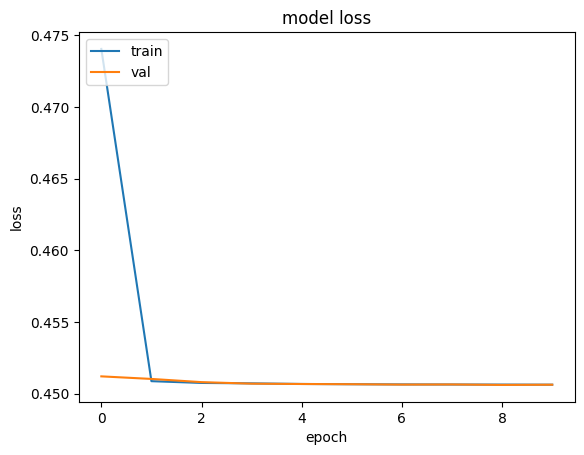

In [21]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['loss'])
plt.plot(model.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [22]:
embeddings = model.layers[0].get_weights()[0] # матрица со всеми эмбедингами

In [23]:
full_word_embeddings = np.zeros((len(tokenizer.fullword_vocab), 100)) # матрица с эмбедингами полных слов + нграммы
id2word = list(tokenizer.fullword_vocab)

for i, word in enumerate(tokenizer.fullword_vocab):
    subwords = tokenizer(word)[0]
    full_word_embeddings[i] = embeddings[[i for i in subwords]].mean(axis=0)

In [24]:
def most_similar_ft(word, embeddings, tokenizer):
    subwords = tokenizer(word)[0]
    word_embedding = embeddings[[i for i in subwords]].sum(axis=0)
    # idxs = [tokenizer.word2id[i] for i in tokenizer.fullword_vocab]
    similar = [id2word[i] for i in
               cosine_distances(word_embedding.reshape(1, -1), full_word_embeddings).argsort()[0][:20]]
    return similar

In [25]:
most_similar_ft('документ', embeddings, tokenizer)

['документ',
 'документа',
 'документу',
 'документы',
 'документе',
 'документах',
 'документов',
 'документальных',
 'документами',
 'документам',
 'документальный',
 'документации',
 'документация',
 'документальные',
 'документальное',
 'документом',
 'документальной',
 'документально',
 'документальном',
 'документального']

In [26]:
most_similar_ft('здоровье', embeddings, tokenizer)

['здоровье',
 'здоровьем',
 'здоровью',
 'здоровья',
 'здоровых',
 'здоровой',
 'фёдоровский',
 'выздоровления',
 'провинциальные',
 'здорового',
 'оборонительные',
 'издательствами',
 'статистические',
 'плодородные',
 'недовольные',
 'фёдоровны',
 'заключительных',
 'законодательные',
 'председательствовал',
 'сравнивали']

In [29]:
most_similar_ft('семья', embeddings, tokenizer)

['семья',
 'семьях',
 'семь',
 'семью',
 'семье',
 'семьям',
 'семьёй',
 'семьи»',
 'семьей',
 'семьями',
 'семьи',
 'северо-восточная',
 'семейное',
 'семнадцать',
 '«семь',
 'семейного',
 'семейный',
 'северо-восточного',
 'семикратный',
 'семёна']